# LSTM prediction

## Access the file in Google Drive

In [1]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Get to the folder we are at
FOLDERNAME = 'Colab\ Notebooks/Quantitative_trading_project/daily_data_prediction'
%cd drive/MyDrive/$FOLDERNAME

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks/Quantitative_trading_project


In [2]:
# Define device
import torch
if torch.cuda.is_available():
  device = torch.device('cuda')
else:
  device = torch.device('cpu')
print('Device:', device)

Device: cpu


## Import Packages

In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
import matplotlib.pyplot as plt

## Data Pre-processing

In [4]:
# Load data
btc_spot = pd.read_csv('data/btc_usdc_spot_data.csv')
btc_futures = pd.read_csv('data/btc_usdc_futures_data.csv')
vix = pd.read_csv('data/btc_usdc_volatility.csv')
funding_rate = pd.read_csv('data/btc_usdt_daily_avg_funding_rate.csv')
usdc_price = pd.read_csv('data/usdc_usdt_price.csv')
true_label = pd.read_csv('data/true_label.csv')

In [5]:
btc_spot.head()
# print(btc_spot.columns)

,timestamp,open,high,low,close,volume,close_time,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume,ignore
0,2021-01-01,28964.54,29680.00,28608.73,29407.93,1736.620480,1.609546e+12,5.084403e+07,28084.0,782.686746,2.292730e+07,0.0
1,2021-01-02,29393.99,33500.00,29027.03,32215.18,4227.234681,1.609632e+12,1.327970e+08,51652.0,2378.789351,7.470016e+07,0.0
2,2021-01-03,32216.13,34851.30,32002.65,33033.26,3523.881120,1.609718e+12,1.179675e+08,52963.0,1907.369385,6.380314e+07,0.0
3,2021-01-04,33040.00,33648.27,28000.00,32017.58,4218.572357,1.609805e+12,1.327577e+08,66533.0,1955.840093,6.144536e+07,0.0
4,2021-01-05,32027.11,34498.00,29882.30,34059.70,3150.244271,1.609891e+12,1.023480e+08,51459.0,1632.076417,5.317519e+07,0.0


In [6]:
# Drop unnecessary columns
columns_to_drop = ['close_time', 'ignore']
btc_spot.drop(columns=columns_to_drop, inplace=True)
btc_futures.drop(columns=columns_to_drop, inplace=True)
usdc_price.drop(columns=columns_to_drop, inplace=True)

In [7]:
# btc_spot.head()
# print(btc_spot.columns)

In [8]:
# Set timestamp as index and convert to datetime
btc_spot['timestamp'] = pd.to_datetime(btc_spot['timestamp'])
btc_spot.set_index('timestamp', inplace=True)
btc_futures['timestamp'] = pd.to_datetime(btc_futures['timestamp'])
btc_futures.set_index('timestamp', inplace=True)
usdc_price['timestamp'] = pd.to_datetime(usdc_price['timestamp'])
usdc_price.set_index('timestamp', inplace=True)
vix['timestamp'] = pd.to_datetime(vix['timestamp'])
vix.set_index('timestamp', inplace=True)
funding_rate['fundingTime'] = pd.to_datetime(funding_rate['fundingTime'])
funding_rate.set_index('fundingTime', inplace=True)
true_label['date'] = pd.to_datetime(true_label['date'])
true_label.set_index('date', inplace=True)

In [9]:
def rename_col(df, name):
  for column in df.columns:
    df.rename(columns={column: f'{name}_{column}'}, inplace=True)
  return df

In [10]:
btc_spot = rename_col(btc_spot, 'btc_spot')
btc_futures = rename_col(btc_futures, 'btc_futures')
usdc_price = rename_col(usdc_price, 'usdc_price')
vix = rename_col(vix, 'vix')
funding_rate = rename_col(funding_rate, 'funding_rate')

In [11]:
# shift because we aim to predict the label for tommorrow
true_label = true_label.shift(-1)

# Merge DataFrames on the timestamp index
df = pd.concat([true_label, btc_spot, btc_futures, vix, funding_rate, usdc_price], axis=1)
df.dropna(inplace=True)
df.head()

,label,btc_spot_open,btc_spot_high,btc_spot_low,btc_spot_close,btc_spot_volume,btc_spot_quote_asset_volume,btc_spot_number_of_trades,btc_spot_taker_buy_base_asset_volume,btc_spot_taker_buy_quote_asset_volume,...,funding_rate_fundingRate,usdc_price_open,usdc_price_high,usdc_price_low,usdc_price_close,usdc_price_volume,usdc_price_quote_asset_volume,usdc_price_number_of_trades,usdc_price_taker_buy_base_asset_volume,usdc_price_taker_buy_quote_asset_volume
2021-01-31,0.0,34302.16,34379.02,32200.04,33130.26,2117.537392,7.047793e+07,36630.0,1119.019733,3.723787e+07,...,0.000484,0.9988,1.0000,0.9987,0.9991,7.353981e+07,7.348597e+07,34086.0,38668988.59,3.864210e+07
2021-02-01,1.0,33120.51,34781.92,32324.02,33545.58,2599.698816,8.775161e+07,49989.0,1354.041359,4.573690e+07,...,0.000394,0.9992,1.0004,0.9988,0.9998,9.845605e+07,9.842217e+07,49399.0,49440414.46,4.942500e+07
2021-02-02,1.0,33530.59,36025.69,33440.86,35516.68,3360.726349,1.171333e+08,52544.0,2049.598887,7.148371e+07,...,0.000677,0.9998,1.0010,0.9990,0.9991,1.145683e+08,1.145063e+08,51110.0,57239459.51,5.721079e+07
2021-02-03,0.0,35500.00,37685.71,35404.21,37661.46,3210.012506,1.177092e+08,58050.0,1674.100465,6.141886e+07,...,0.000778,0.9991,1.0005,0.9971,0.9989,1.735075e+08,1.733302e+08,66274.0,87600282.83,8.751368e+07
2021-02-04,1.0,37637.44,38759.09,36192.89,36976.61,3025.320823,1.136568e+08,59009.0,1554.302399,5.848118e+07,...,0.000551,0.9988,0.9998,0.9979,0.9990,1.546301e+08,1.544414e+08,58183.0,77672578.79,7.758041e+07


In [12]:
df.shape

(1044, 30)

In [13]:
# Split data into training and testing sets by date 2023-06-30
training_data = df.loc[df.index <= '2023-06-30']
testing_data = df.loc[df.index > '2023-06-30']

# Print shapes to verify the split
print(f'Training data shape: {training_data.shape}')
print(f'Testing data shape: {testing_data.shape}')

Training data shape: (710, 30)
Testing data shape: (334, 30)


In [14]:
# # Normalize the dataset
scaler = MinMaxScaler()
training_data = scaler.fit_transform(training_data)
testing_data = scaler.transform(testing_data)

training_data

array([[0.        , 0.32262502, 0.30379961, ..., 0.03484041, 0.02993578,
        0.02931342],
       [1.        , 0.29856075, 0.31190161, ..., 0.05209275, 0.03894276,
        0.03814917],
       [1.        , 0.30691202, 0.33691284, ..., 0.05402044, 0.04546425,
        0.04452902],
       ...,
       [1.        , 0.24937831, 0.23014   , ..., 0.08400951, 0.1285022 ,
        0.12592653],
       [0.        , 0.23656792, 0.23256597, ..., 0.08241643, 0.12063507,
        0.11823571],
       [1.        , 0.24402598, 0.24133781, ..., 0.13155286, 0.28054108,
        0.27499861]])

In [15]:
training_data.shape

(710, 30)

### Create sequences for LSTM model

In [16]:
SEQ_LENGTH = 5  # Using the past 4 days + current day to predict the next day

# Function to create sequences
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(seq_length, len(data)):
        x = data[i-seq_length:i, 1:]  # Use all columns except the first for the sequence
        y = data[i, 0]  # Use the first column for the label
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

In [17]:
# Create sequences for training and testing data
X_train, y_train = create_sequences(training_data, SEQ_LENGTH)
X_test, y_test = create_sequences(testing_data, SEQ_LENGTH)

In [18]:
print(X_train)
print(X_train.shape)
print(y_train)
print(y_train.shape)

[[[0.32262502 0.30379961 0.30030067 ... 0.03484041 0.02993578 0.02931342]
  [0.29856075 0.31190161 0.30284898 ... 0.05209275 0.03894276 0.03814917]
  [0.30691202 0.33691284 0.32580479 ... 0.05402044 0.04546425 0.04452902]
  [0.34701901 0.37029452 0.36615998 ... 0.0711049  0.0708517  0.06935989]
  [0.39054792 0.39187934 0.3823707  ... 0.06198921 0.06255025 0.06122035]]

 [[0.29856075 0.31190161 0.30284898 ... 0.05209275 0.03894276 0.03814917]
  [0.30691202 0.33691284 0.32580479 ... 0.05402044 0.04546425 0.04452902]
  [0.34701901 0.37029452 0.36615998 ... 0.0711049  0.0708517  0.06935989]
  [0.39054792 0.39187934 0.3823707  ... 0.06198921 0.06255025 0.06122035]
  [0.3768095  0.38398527 0.39086783 ... 0.06887189 0.05806877 0.05684944]]

 [[0.30691202 0.33691284 0.32580479 ... 0.05402044 0.04546425 0.04452902]
  [0.34701901 0.37029452 0.36615998 ... 0.0711049  0.0708517  0.06935989]
  [0.39054792 0.39187934 0.3823707  ... 0.06198921 0.06255025 0.06122035]
  [0.3768095  0.38398527 0.3908678

In [19]:
# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

print(X_train)
print(X_train.shape)

tensor([[[0.3226, 0.3038, 0.3003,  ..., 0.0348, 0.0299, 0.0293],
         [0.2986, 0.3119, 0.3028,  ..., 0.0521, 0.0389, 0.0381],
         [0.3069, 0.3369, 0.3258,  ..., 0.0540, 0.0455, 0.0445],
         [0.3470, 0.3703, 0.3662,  ..., 0.0711, 0.0709, 0.0694],
         [0.3905, 0.3919, 0.3824,  ..., 0.0620, 0.0626, 0.0612]],

        [[0.2986, 0.3119, 0.3028,  ..., 0.0521, 0.0389, 0.0381],
         [0.3069, 0.3369, 0.3258,  ..., 0.0540, 0.0455, 0.0445],
         [0.3470, 0.3703, 0.3662,  ..., 0.0711, 0.0709, 0.0694],
         [0.3905, 0.3919, 0.3824,  ..., 0.0620, 0.0626, 0.0612],
         [0.3768, 0.3840, 0.3909,  ..., 0.0689, 0.0581, 0.0568]],

        [[0.3069, 0.3369, 0.3258,  ..., 0.0540, 0.0455, 0.0445],
         [0.3470, 0.3703, 0.3662,  ..., 0.0711, 0.0709, 0.0694],
         [0.3905, 0.3919, 0.3824,  ..., 0.0620, 0.0626, 0.0612],
         [0.3768, 0.3840, 0.3909,  ..., 0.0689, 0.0581, 0.0568],
         [0.4049, 0.4369, 0.4243,  ..., 0.0649, 0.0514, 0.0503]],

        ...,

     

In [20]:
# Create DataLoader
train_data = TensorDataset(X_train, y_train)
test_data = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_data, batch_size=32, shuffle=False)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

## Build LSTM Model

In [21]:
# Define the LSTM model
class FeatureEmbedding(nn.Module):
    def __init__(self, input_dim, embed_dim):
        super().__init__()
        self.embed = nn.Linear(input_dim, embed_dim)

    def forward(self, x):
        return torch.relu(self.embed(x))

class LSTM(nn.Module):
    def __init__(self, input_size, hidden_layer_size, output_size, embed_dim):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        # Embedding layer for all features
        self.feature_embed = FeatureEmbedding(input_size, embed_dim)

        # LSTM layer
        self.lstm = nn.LSTM(embed_dim, hidden_layer_size, batch_first=True)

        # Linear layer
        self.linear = nn.Linear(hidden_layer_size, output_size)
        self.sigmoid = nn.Sigmoid()  # Added Sigmoid for binary classification

    def forward(self, x):
        # Apply embeddings
        x = self.feature_embed(x)

        # LSTM layer
        h_0 = torch.zeros(1, x.size(0), self.hidden_layer_size).to(device).requires_grad_()
        c_0 = torch.zeros(1, x.size(0), self.hidden_layer_size).to(device).requires_grad_()
        lstm_out, _ = self.lstm(x, (h_0.detach(), c_0.detach()))

        # Linear layer
        predictions = self.linear(lstm_out[:, -1, :])
        return self.sigmoid(predictions)

In [25]:
# hyperparameters
input_size = X_train.shape[2]
hidden_layer_size = 50
embeded_dim = 50
output_size = 1 # Binary classification
learning_rate = 0.001

In [26]:
# Initialize model and move it to the GPU
model = LSTM(input_size, hidden_layer_size, output_size, embeded_dim).to(device)
loss_function = nn.BCELoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

## Training & Testing

In [27]:
# recording losses and accuracies for each epoch
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

In [28]:
epochs = 100

# Training model
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        y_pred = model(X_batch)
        y_batch = y_batch.unsqueeze(1).float()  # Ensure y_batch is float and has the correct shape
        loss = loss_function(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        # Calculate accuracy
        predicted = (y_pred > 0.5).float()
        correct_train += (predicted == y_batch).sum().item()
        total_train += y_batch.size(0)

    train_losses.append(running_loss / len(train_loader))
    train_accuracy = 100 * correct_train / total_train
    train_accuracies.append(train_accuracy)

    model.eval()
    test_loss = 0.0
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_pred = model(X_batch)
            y_batch = y_batch.unsqueeze(1).float()  # Ensure y_batch is float and has the correct shape
            loss = loss_function(y_pred, y_batch)
            test_loss += loss.item()

            # Calculate accuracy
            predicted = (y_pred > 0.5).float()
            correct_test += (predicted == y_batch).sum().item()
            total_test += y_batch.size(0)

    test_losses.append(test_loss / len(test_loader))
    test_accuracy = 100 * correct_test / total_test
    test_accuracies.append(test_accuracy)

    print(f'Epoch {epoch+1}/{epochs}, Training Loss: {train_losses[-1]}, Testing Loss: {test_losses[-1]}, Training Accuracy: {train_accuracy}%, Testing Accuracy: {test_accuracy}%')

Epoch 1/100, Training Loss: 0.6593265533447266, Testing Loss: 0.620662737976421, Training Accuracy: 62.269503546099294%, Testing Accuracy: 66.8693009118541%
Epoch 2/100, Training Loss: 0.655471287343813, Testing Loss: 0.6257058923894708, Training Accuracy: 63.12056737588652%, Testing Accuracy: 66.8693009118541%
Epoch 3/100, Training Loss: 0.6507005821103635, Testing Loss: 0.6247256398200989, Training Accuracy: 63.12056737588652%, Testing Accuracy: 66.8693009118541%
Epoch 4/100, Training Loss: 0.65025111903315, Testing Loss: 0.625428167256442, Training Accuracy: 63.12056737588652%, Testing Accuracy: 66.8693009118541%
Epoch 5/100, Training Loss: 0.6493464786073436, Testing Loss: 0.6269115209579468, Training Accuracy: 63.12056737588652%, Testing Accuracy: 66.8693009118541%
Epoch 6/100, Training Loss: 0.6482747572919597, Testing Loss: 0.6282469576055353, Training Accuracy: 63.12056737588652%, Testing Accuracy: 66.8693009118541%
Epoch 7/100, Training Loss: 0.6474019625912542, Testing Loss: 

### Visualize data

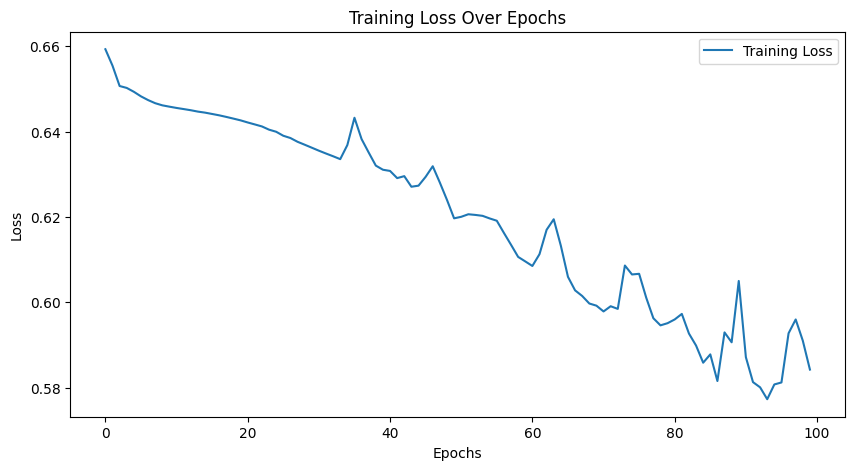

In [29]:
# Plotting the training loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()

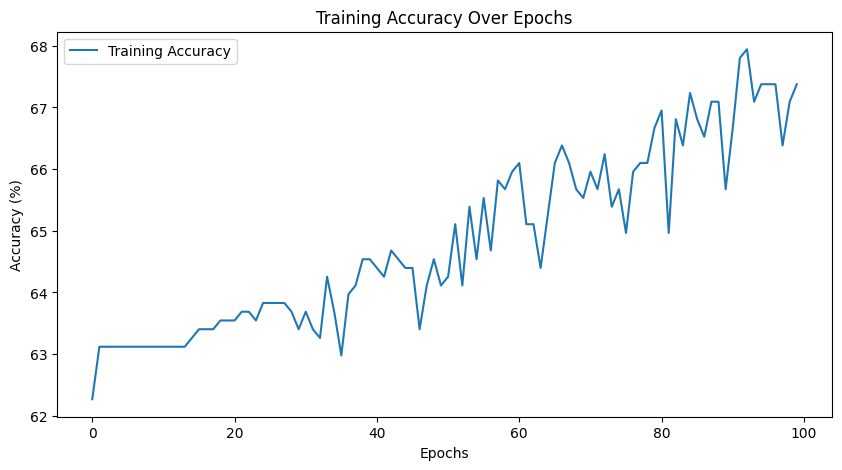

In [30]:
# Plotting the training accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training Accuracy Over Epochs')
plt.legend()
plt.show()

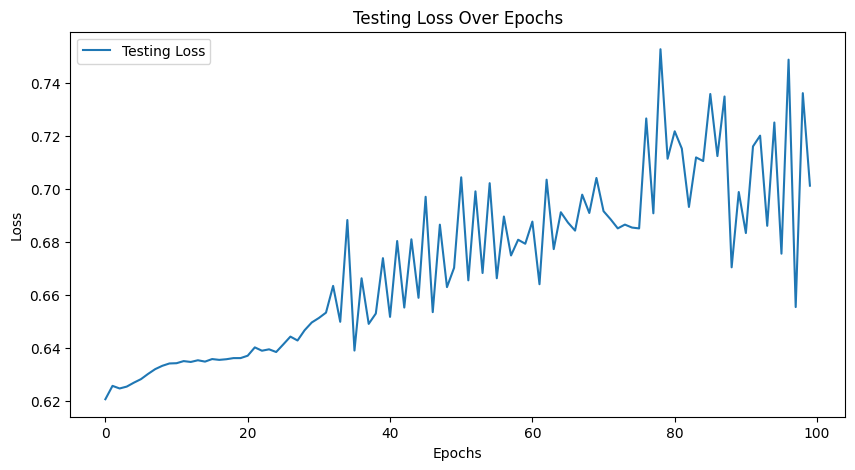

In [31]:
# Plotting the testing loss
plt.figure(figsize=(10, 5))
plt.plot(test_losses, label='Testing Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Testing Loss Over Epochs')
plt.legend()
plt.show()

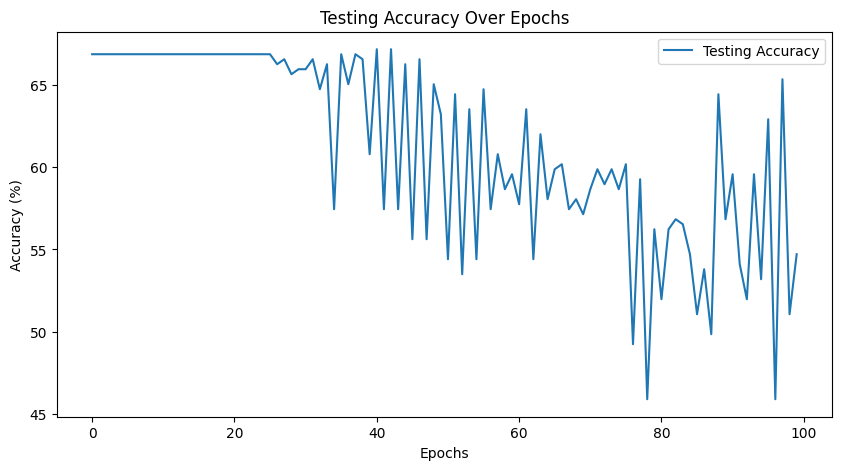

In [32]:
# Plotting the testing accuracy
plt.figure(figsize=(10, 5))
plt.plot(test_accuracies, label='Testing Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Testing Accuracy Over Epochs')
plt.legend()
plt.show()

## Output result

In [33]:
# # Save testing results to CSV
# results_df = pd.DataFrame({
#     'Date': dates_list,
#     'Predicted': [p[0] for p in predictions_list],
#     'Actual': [a[0] for a in actuals_list]
# })
# results_df.to_csv('testing_results.csv', index=False)
# print('Testing results saved to testing_results.csv')